# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [3]:
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv  # For loading environment variables from a .env file



/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [4]:
# Alle PDFs aus dem Verzeichnis "data" laden
pdf_files = glob.glob("data/*.pdf")  # z. B. "data/nihms-*.pdf"

# Inhalte aller PDFs extrahieren und in einem String sammeln
all_text = ""

for pdf_path in pdf_files:
    reader = PdfReader(pdf_path)
    for page in reader.pages:
        text = page.extract_text()
        if text:
            all_text += text + "\n"

# Ergebnis prüfen
print(f"Anzahl geladener PDFs: {len(pdf_files)}")
print(f"Gesamtlänge des extrahierten Texts: {len(all_text)} Zeichen")
print(all_text[:1000])  # Vorschau: erste 1000 Zeichen

Anzahl geladener PDFs: 1
Gesamtlänge des extrahierten Texts: 48630 Zeichen
High and normal protein diets improve body composition and 
glucose control in adults with type 2 diabetes: A randomized 
trial
Julianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. 
McDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1
1Department of Nutrition Sciences, University of Alabama at Birmingham
2Department of Pediatrics, University of Colorado Anschutz Medical Campus
3Department of Family and Community Medicine, University of Alabama at Birmingham
4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, 
Aurora, Colorado
5Anschutz Health and Wellness Center, University of Colorado Anschutz Medical Campus
Abstract
Objective:  Weight loss of ≥10% improves glucose control and may remit type 2 diabetes 
(T2D). High protein (HP) diets are commonly used for weight loss, but whether protein 
sources, especially red meat, im

"""
## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.
"""

In [5]:
# Konfiguration: 2000 Zeichen pro Chunk, 200 Zeichen Überlappung
splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=200
)

# Text zerschneiden
chunks = splitter.split_text(all_text)

# Ergebnis prüfen
print(f"Anzahl Chunks: {len(chunks)}")
print(f"Beispiel-Chunk:\n{chunks[0][:300]}...")  # zeige die ersten 300 Zeichen


Anzahl Chunks: 28
Beispiel-Chunk:
High and normal protein diets improve body composition and 
glucose control in adults with type 2 diabetes: A randomized 
trial
Julianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. 
McDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1
1Department of Nu...


In [6]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 28
Preview of the first chunk: High and normal protein diets improve body composition and 
glucose control in adults with type 2 diabetes: A randomized 
trial
Julianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3,


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model.

In [7]:
# Teilt Text in 128-Token große, nicht überlappende Chunks auf, optimiert für das Modell „paraphrase-multilingual-MiniLM-L12-v2“.
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [8]:
# Zerlegt alle Textstücke nochmals in 128-Token-Chunks und sammelt sie in einer Liste.
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 120
High and normal protein diets improve body composition and glucose control in adults with type 2 diabetes: A randomized trial Julianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. McDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1 1Department of Nutrition Sciences, University of Alabama at Birmingham 2Department of Pediatrics, University of Colorado Anschutz Medical Campus 3Department of Family and Community Medicine, University of Alabama at Birmingham


In [9]:
# Tokenisiert die ersten 10 Chunks auf 128 Tokens, wandelt IDs zurück zu lesbaren Tokens und zeigt sie an.
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁High', '▁and', '▁normal', '▁protein', '▁die', 'ts', '▁improve', '▁body', '▁composition', '▁and', '▁gluco', 'se', '▁control', '▁in', '▁adults', '▁with', '▁type', '▁2', '▁diabetes', ':', '▁A', '▁random', 'ized', '▁trial', '▁Julian', 'ne', '▁G', '.', '▁C', 'lina', '1', ',', '▁R', '.', '▁Drew', '▁Say', 'er', '1', ',', '3', ',', '▁Z', 'ha', 'ox', 'ing', '▁Pan', '2', ',', '▁Caroline', '▁W', '.', '▁Cohen', '3', ',', '▁Michael', '▁T', '.', '▁Mc', 'Der', 'm', 'ott', '4', ',', '▁Victoria', '▁A', '.', '▁Cate', 'na', 'cci', '4', ',', '▁Holl', 'y', '▁R', '.', '▁Wy', 'att', '1,5', ',', '▁James', '▁O', '.', '▁Hill', '1', '▁1', 'De', 'part', 'ment', '▁of', '▁Nutrition', '▁Science', 's', ',', '▁University', '▁of', '▁Alabama', '▁at', '▁Birmingham', '▁2', 'De', 'part', 'ment', '▁of', '▁Pediatri', 'cs', ',', '▁University', '▁of', '▁Colorado', '▁An', 'schutz', '▁Medical', '▁Campus', '▁3', 'De', 'part', 'ment', '▁of', '▁Family', '▁and', '▁Community', '▁Medicine', ',', '▁University', '▁of'

In [10]:
#Jetzt wird ein Modell verwendet, das speziell für deutsche Texte optimiert ist, dadurch werden die Tokenisierung 
# und spätere Embeddings besser auf Deutsch angepasst.
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', 'High', 'and', 'normal', 'pro', '##te', '##in', 'die', '##ts', 'im', '##pro', '##ve', 'bo', '##dy', 'comp', '##osition', 'and', 'gl', '##uc', '##ose', 'con', '##trol', 'in', 'ad', '##ult', '##s', 'with', 'type', '2', 'di', '##abet', '##es', ':', 'A', 'ran', '##dom', '##ized', 'tri', '##al', 'Julian', '##ne', 'G', '.', 'Clin', '##a', '##1', ',', 'R', '.', 'Dre', '##w', 'Say', '##er', '##1', ',', '3', ',', 'Z', '##ha', '##ox', '##ing', 'Pan', '##2', ',', 'Caroline', 'W', '.', 'Cohen', '##3', ',', 'Michael', 'T', '.', 'Mc', '##Der', '##mo', '##tt', '##4', ',', 'Victoria', 'A', '.', 'Cat', '##ena', '##cc', '##i', '##4', ',', 'Holly', 'R', '.', 'Wy', '##att', '##1', ',', '5', ',', 'James', 'O', '.', 'Hill', '##1', '1', '##De', '##partment', 'of', 'Nut', '##rit', '##ion', 'Sciences', ',', 'University', 'of', 'Ala', '##ba', '##ma', 'at', 'Birmingham', '2', '##De', '##partment', 'of', 'Ped', '##iat', '##ric', '##s', ',', '[SEP]']
Chunk 1: ['[CLS]', '4', '##Division', 'of', '

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [11]:
# Wandelt alle Token-Chunks direkt in Embeddings um und speichert sie als NumPy-Array.
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

/tmp/ipykernel_14922/4140566380.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")


"""
## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.
"""

In [12]:
#Der Code gibt die Anzahl der Dimensionen jedes Embedding-Vektors aus – also die Vektorgröße.
# chunk_embeddings = [
#  [0.12, -0.88, 0.45, 0.77, ..., 0.33],  # ➔ Chunk 1 (ein Embedding)
#  [0.34, -0.22, 0.78, 0.11, ..., -0.50], # ➔ Chunk 2
#  [0.91,  0.05, 0.12, -0.99, ..., 0.71], # ➔ Chunk 3
#]
# shape[1]-> Grösse der zweiten Dimension, also die Anzahl der Dimensionen jedes Embedding-Vektors.
d = chunk_embeddings.shape[1]
print(f"Anzahl der Dimensionen pro Embedding: {d}")

Anzahl der Dimensionen pro Embedding: 1024


In [13]:
# Der Code erstellt einen FAISS-Index für effiziente Ähnlichkeitssuche, fügt Embeddings hinzu 
# und gibt die Anzahl der gespeicherten Vektoren aus.
# L2-Distanz (euklidische Distanz) verwendet
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 120


In [14]:
#Der Code speichert den FAISS-Index und die zugehörigen Text-Chunks lokal ab, um sie später wiederverwenden zu können.
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [15]:
#Musste hier zuerst faiss folder erstellen!
#Der Code lädt den gespeicherten FAISS-Index und die Chunk-Texte wieder aus Dateien und prüft, 
#ob die Anzahl der geladenen Chunks mit den ursprünglichen übereinstimmt.
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

28
120


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [16]:
# Fit UMAP on the full dataset embeddings
# Der Code trainiert UMAP auf den Embeddings, um sie auf 2D zu reduzieren, und definiert eine Funktion, 
# die beliebige Embeddings mithilfe dieser UMAP-Transformation in zwei Dimensionen projiziert – z. B. für die Visualisierung.
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   1%|          | 1/120 [00:01<03:49,  1.93s/it]/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/pyt

Projected dataset embeddings shape: (120, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [18]:
#Die Funktion retrieve(query, k=5) berechnet ein Embedding für die Anfrage, sucht die k ähnlichsten Chunks im 
#FAISS-Index und gibt die zugehörigen Texte, Embeddings und Distanzen zurück.
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [chunks[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [19]:
query = "machine learning algorithms"
results, result_embeddings, distances = retrieve(query, k=2)
print("Retrieved document preview:")
print(results[0][:300])

IndexError: list index out of range

In [ ]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

NameError: name 'result_embeddings' is not defined

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

NameError: name 'projected_result_embeddings' is not defined

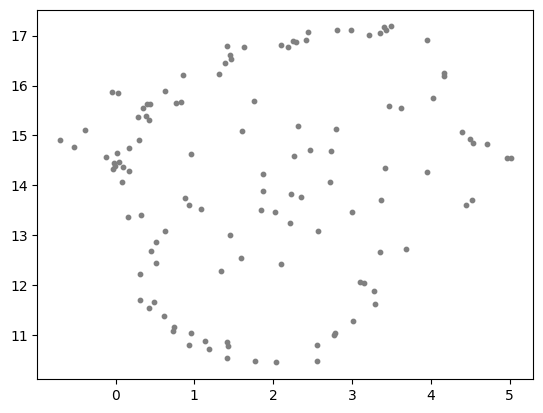

In [ ]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Original Query Text'  # Replace with your actual query text if needed
plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Hogwarts')
plt.legend()
plt.show()


## Attach Retrieved Results to LLM

- Combine learnings from week 1 with approach from this week to inject your data into prompts and create a simple question answering system

In [20]:
#🪄 Schritt 1: Frage stellen + relevante Text-Chunks abrufen

def retrieve_context(query, k=3):
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    return [chunks[i] for i in indices[0] if i < len(chunks)]


In [21]:
#🪄 Schritt 2: Prompt zusammenbauen
def build_prompt(query, context_chunks):
    context = "\n\n".join(context_chunks)
    return f"""
Answer the following question based only on the context below.

Context:
{context}

Question:
{query}

Answer:
"""


In [24]:
# 1. Importiere Module
from openai import OpenAI
import os
from dotenv import load_dotenv

# 2. Lade API-Key
load_dotenv()
key = os.getenv("OPENAI_API_KEY")

# 3. Erstelle den Client GLOBAL
client = OpenAI(api_key=key)

# 4. Definiere deine Funktion
def answer_question(query):
    """
    Sendet die Nutzerfrage an OpenAI GPT, mit Kontext.
    """
    context_chunks = retrieve_context(query)
    prompt = build_prompt(query, context_chunks)

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content


In [25]:
query = "What does the document say about machine learning?"
answer = answer_question(query)
print(answer)


The document does not provide any specific information about machine learning.


In [26]:
answerNew = answer_question("What are the effects of exercise on brain function?")
print(answerNew)

Exercise has been shown to improve brain function by increasing blood flow and oxygenation to the brain, promoting the growth of new brain cells, and enhancing cognitive function such as memory and decision-making.
